In [371]:
# importing necessary libraries
import requests
import json

from io import BytesIO
import zipfile

import pandas as pd
import geopandas as gpd
import numpy as np
import re

import datetime
from datetime import date

# Geocoding
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Mapping
import folium
from shapely.geometry import shape

# Retrieving Data

In [372]:
# Package list of the City of Toronto open data portal
packages_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_list"

# Make the HTTP request
response = requests.get(packages_url)

# Use the json module to load CKAN's response into a dictionary
response_dict = json.loads(response.content)

# Check the contents of the response
assert response_dict['success'] is True  # make sure if response is OK
#response_dict

In [373]:
# Base url
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"

# API Package for parking tickets
ticket_name = { "name_or_id": "parking-tickets"}
ticket_pack = requests.get(url, params = ticket_name).json()
#ticket_pack

# API Package for green p parking
green_p_name = { "id": "green-p-parking"}
green_p_pack = requests.get(url, params = green_p_name).json()
#green_p_pack

# API Package for neighbourhood polygons
neighbourhoods = { "id": "neighbourhoods"}
neighbourhoods_pack = requests.get(url, params = neighbourhoods).json()
#neighbourhoods_pack

# API Package for neighbourhood profiles
nb_profile = { "id": "neighbourhood-profiles"}
nb_profile_pack = requests.get(url, params = nb_profile).json()
#nb_profile_pack

# API Package for neighbourhood profiles
addresses = { "id": "address-points-municipal-toronto-one-address-repository"}
addresses_pack = requests.get(url, params = addresses).json()
#addresses_pack

In [374]:
# Get URL for addresses lookup from the package
data_url = addresses_pack['result']['resources'][2]['url']
print('Data url:     ' + data_url)

addresses = gpd.read_file(data_url)
print(addresses.shape)
print(addresses.columns)
addresses.head(1)

Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/abedd8bc-e3dd-4d45-8e69-79165a76e4fa/resource/eba07dba-8645-45f8-950c-0381a0dcaa1b/download/municipal-address-points-wgs84-latitude-longitude.zip
(525368, 23)
Index(['GEO_ID', 'LINK', 'MAINT_STAG', 'ADDRESS', 'LFNAME', 'LO_NUM',
       'LONUMSUF', 'HINUM', 'HINUMSUF', 'ARC_SIDE', 'DISTANCE', 'FCODE',
       'FCODE_DES', 'CLASS', 'NAME', 'X', 'Y', 'LONGITUDE', 'LATITUDE',
       'OBJECTID', 'MUN_NAME', 'WARD_NAME', 'geometry'],
      dtype='object')


GEO_ID     LINK MAINT_STAG ADDRESS          LFNAME  LO_NUM LONUMSUF  \
0  5729529  5729516    REGULAR     399  Lake Promenade     399     None   

   HINUM HINUMSUF ARC_SIDE  ...  CLASS  NAME           X            Y  \
0    NaN     None        L  ...   Land  None  301607.151  4827443.931   

   LONGITUDE  LATITUDE   OBJECTID   MUN_NAME            WARD_NAME  \
0 -79.539542  43.58693  1491585.0  Etobicoke  Etobicoke-Lakeshore   

                           geometry  
0  POINT (-8854300.947 5401738.297)  

[1 rows x 23 columns]

In [375]:
# Get URL for neighbourhood profiles from the package
data_url = nb_profile_pack['result']['resources'][0]['url']
print('Data url:     ' + data_url)

# Read the neighbourohod profiles into a pandas dataframe
nb_profiles = pd.read_csv(data_url, thousands=',')

print("unique # of neighbourhoods: " + str(nb_profile_cross_tab['variable'].nunique()))
print("unique variables/characteristics: " + str(nb_profile_cross_tab['Characteristic'].nunique()))
print(nb_profiles.shape)
nb_profiles.head(1)

Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/7f8eee5e-85fb-415c-aef3-c3bd4998445f
unique # of neighbourhoods: 141
unique variables/characteristics: 1651
(2383, 146)


_id                   Category                      Topic      Data Source  \
0    1  Neighbourhood Information  Neighbourhood Information  City of Toronto   

         Characteristic City of Toronto Agincourt North  \
0  Neighbourhood Number             NaN             129   

  Agincourt South-Malvern West Alderwood Annex  ... Willowdale West  \
0                          128        20    95  ...              37   

  Willowridge-Martingrove-Richview Woburn Woodbine Corridor Woodbine-Lumsden  \
0                                7    137                64               60   

  Wychwood Yonge-Eglinton Yonge-St.Clair York University Heights  \
0       94            100             97                      27   

  Yorkdale-Glen Park  
0                 31  

[1 rows x 146 columns]

In [376]:
# get historical 140 neighbourhood geographies url from the package
data_url = neighbourhoods_pack['result']['resources'][1]['url']
print('Package Name: ' + str(neighbourhoods_pack['result']['resources'][1]['name']))
print('Data url:     ' + data_url)

# read neighbourhood geographies into pandas dataframe
neighbourhood_df = pd.read_csv(data_url)
neighbourhood_df.head(1)

Package Name: Neighbourhoods - historical 140
Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/ef8a43bb-ebfc-4840-bb6b-46a571072838


_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_SHORT_CODE  \
0    1  2501286      26022481             NaN               30   

   AREA_LONG_CODE                 AREA_NAME                 AREA_DESC  \
0              30  Brookhaven-Amesbury (30)  Brookhaven-Amesbury (30)   

                         CLASSIFICATION CLASSIFICATION_CODE  OBJECTID  \
0  Not an NIA or Emerging Neighbourhood                 NaN  17818369   

                                            geometry  
0  {"type": "Polygon", "coordinates": [[[-79.5029...

In [377]:
# convert GeoJSON geometry object to shapely shape object
neighbourhood_df['geo'] = neighbourhood_df.geometry.apply(lambda x: shape(eval(x.replace('=',':'))))

# Convert the pandas dataframe to a geodataframe
nb_geos = gpd.GeoDataFrame(neighbourhood_df, geometry='geo')

print(nb_geos.shape)
print(type(nb_geos))
nb_geos.head(1)

(140, 13)
<class 'geopandas.geodataframe.GeoDataFrame'>


_id  AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_SHORT_CODE  \
0    1  2501286      26022481             NaN               30   

   AREA_LONG_CODE                 AREA_NAME                 AREA_DESC  \
0              30  Brookhaven-Amesbury (30)  Brookhaven-Amesbury (30)   

                         CLASSIFICATION CLASSIFICATION_CODE  OBJECTID  \
0  Not an NIA or Emerging Neighbourhood                 NaN  17818369   

                                            geometry  \
0  {"type": "Polygon", "coordinates": [[[-79.5029...   

                                                 geo  
0  POLYGON ((-79.50296 43.69574, -79.50415 43.696...

In [378]:
# Plot the neighbourhoods on a map
m = folium.Map(location=[43.72262152227271, -79.38081244593121], zoom_start=11, tiles='CartoDB positron')

for _, r in nb_geos.iterrows():
    # Plot each neighbourhood onto a folium map
    sim_geo = gpd.GeoSeries(r['geo'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['AREA_NAME']).add_to(geo_j)
    geo_j.add_to(m)
m

In [379]:
# Get green P url from the package
data_url = green_p_pack["result"]['resources'][0]['url']
print('Data url:     ' + data_url)

# request object from url
r = requests.get(data_url)

# convert to json object
p_parking = r.json()

# Read data into pandas dataframe
green_p = pd.DataFrame(p_parking['carparks'])
print(green_p.shape)

print(green_p.columns)

# Convert Green P Parking dataframe to geopandas dataframe
green_p_geo = gpd.GeoDataFrame(
    green_p[['id'
    ,'address'
    ,'lat'
    ,'lng'
    ,'rate'
    ,'rate_half_hour'
    ,'payment_methods'
    ,'carpark_type'
    ,'is_ttc'
    ,'is_under_construction'
    ,'capacity']], geometry=gpd.points_from_xy(green_p.lng, green_p.lat)
)

green_p_geo.head(2)

Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/b66466c3-69c8-4825-9c8b-04b270069193/resource/8549d588-30b0-482e-b872-b21beefdda22/download/green-p-parking-2019.json
(252, 29)
Index(['id', 'slug', 'address', 'lat', 'lng', 'rate', 'carpark_type',
       'carpark_type_str', 'is_ttc', 'is_under_construction', 'changing_rates',
       'rate_half_hour', 'capacity', 'max_height', 'bike_racks',
       'payment_methods', 'payment_options', 'rate_details',
       'monthly_permit_status', 'monthly_permit_quantity',
       'monthly_permit_price', 'map_marker_logo', 'alert_box',
       'enable_streetview', 'streetview_lat', 'streetview_long',
       'streetview_yaw', 'streetview_pitch', 'streetview_zoom'],
      dtype='object')


id                 address                 lat                lng  \
0  1  20 Charles Street East  43.669282202140174  -79.3852894625656   
1  3      13 Isabella Street           43.667577         -79.384707   

                rate rate_half_hour  \
0  $2.50 / Half Hour          2.50    
1  $3.00 / Half Hour           3.00   

                                     payment_methods carpark_type  is_ttc  \
0  [Bills, Coins, Charge (Visa / Mastercard / Ame...       garage   False   
1  [Coins, Charge (Visa / Mastercard / American E...      surface   False   

   is_under_construction capacity                    geometry  
0                  False      641  POINT (-79.38529 43.66928)  
1                  False       33  POINT (-79.38471 43.66758)

In [380]:
# Read in parking tickets data 2016-2020
years = ['2016.zip','2017.zip','2018.zip','2019.zip','2020.zip']

agg_parking_tickets = []

for metadata in ticket_pack['result']['resources']:
    if any(year in metadata['url'] for year in years):
        #print(metadata['url'])
        r = requests.get(metadata['url'])
        buf1 = BytesIO(r.content)
        with zipfile.ZipFile(buf1,'r') as f:
            for name in f.namelist():
                if name.endswith('.csv'):
                    with f.open(name) as zd:
                        df = pd.read_csv(zd)
                        agg_parking_tickets.append(df)

p_tickets = pd.concat(agg_parking_tickets)
print(p_tickets.shape)
p_tickets.head()

(10060877, 11)


tag_number_masked  date_of_infraction  infraction_code  \
0          ***14036            20160429              5.0   
1          ***36810            20160429              5.0   
2          ***26310            20160429              3.0   
3          ***27491            20160429            307.0   
4          ***02237            20160429              9.0   

           infraction_description  set_fine_amount  time_of_infraction  \
0  PARK-SIGNED HWY-PROHIBIT DY/TM               50              1145.0   
1  PARK-SIGNED HWY-PROHIBIT DY/TM               50              1145.0   
2        PARK ON PRIVATE PROPERTY               30              1146.0   
3  PARK VEHICLE OUTSIDE OF SPACE                30              1146.0   
4  STOP-SIGNED HWY-PROHIBIT TM/DY               60              1146.0   

  location1           location2 location3 location4 province  
0        NR  443 UNIVERSITY AVE       NaN       NaN       ON  
1       OPP  95 WELLINGTON ST W       NaN       NaN       ON  
2       NaN      130 VAUGHAN RD       NaN       NaN       ON  
3       NaN       1010 YONGE ST       NaN       NaN       ON  
4       OPP    190 ELIZABETH ST       NaN       NaN       ON

# Investigate and Clean Parking Tickets Dataseet

In [381]:
p_tickets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10060877 entries, 0 to 153663
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   tag_number_masked       object 
 1   date_of_infraction      int64  
 2   infraction_code         float64
 3   infraction_description  object 
 4   set_fine_amount         int64  
 5   time_of_infraction      float64
 6   location1               object 
 7   location2               object 
 8   location3               object 
 9   location4               object 
 10  province                object 
dtypes: float64(2), int64(2), object(7)
memory usage: 921.1+ MB


In [382]:
p_tickets.describe()

date_of_infraction  infraction_code  set_fine_amount  \
count        1.006088e+07     1.006088e+07     1.006088e+07   
mean         2.017905e+07     8.631314e+01     4.920667e+01   
std          1.365851e+04     1.318593e+02     4.786575e+01   
min          2.016010e+07     1.000000e+00     0.000000e+00   
25%          2.017021e+07     4.000000e+00     3.000000e+01   
50%          2.018043e+07     9.000000e+00     3.000000e+01   
75%          2.019071e+07     2.070000e+02     5.000000e+01   
max          2.020123e+07     4.370000e+02     5.000000e+02   

       time_of_infraction  
count        1.005340e+07  
mean         1.152651e+03  
std          6.066544e+02  
min          0.000000e+00  
25%          8.000000e+02  
50%          1.205000e+03  
75%          1.616000e+03  
max          3.512000e+03

In [383]:
# Check missing values
p_tickets.isna().sum()

tag_number_masked               0
date_of_infraction              0
infraction_code                 2
infraction_description          0
set_fine_amount                 0
time_of_infraction           7473
location1                  961635
location2                    1157
location3                 9361614
location4                 9359364
province                        3
dtype: int64

In [384]:
# Check empty infraction_codes
p_tickets[p_tickets['infraction_code'].isna()]

# optional to fill null values but would not have any effect on identifying the top 20 infraction codes

tag_number_masked  date_of_infraction  infraction_code  \
129565          ***38875            20160916              NaN   
737966          ***56038            20170901              NaN   

              infraction_description  set_fine_amount  time_of_infraction  \
129565      PARK ON PRIVATE PROPERTY               30              1042.0   
737966  PARK IN ACCESSIBLE NO PERMIT              450              1140.0   

       location1         location2 location3 location4 province  
129565       NaN  2075 BAYVIEW AVE       NaN       NaN       ON  
737966       NaN  941 PROGRESS AVE       NaN       NaN       ON

In [385]:
# Check for duplicates
dupes = p_tickets[p_tickets.duplicated(keep=False) == True]

print(dupes.shape)
dupes.head()

(4, 11)


tag_number_masked  date_of_infraction  infraction_code  \
400669          ***49522            20180317             29.0   
400673          ***49522            20180317             29.0   
557210          ***54959            20180414              3.0   
557212          ***54959            20180414              3.0   

                infraction_description  set_fine_amount  time_of_infraction  \
400669  PARK PROHIBITED TIME NO PERMIT               30              1758.0   
400673  PARK PROHIBITED TIME NO PERMIT               30              1758.0   
557210        PARK ON PRIVATE PROPERTY               30               346.0   
557212        PARK ON PRIVATE PROPERTY               30               346.0   

       location1            location2 location3 location4 province  
400669        NR     8 ST HILDA'S AVE       NaN       NaN       ON  
400673        NR     8 ST HILDA'S AVE       NaN       NaN       ON  
557210       NaN  710 TRETHEWEY DRIVE       NaN       NaN       ON  
557212       NaN  710 TRETHEWEY DRIVE       NaN       NaN       ON

In [386]:
# Drop duplicates
tickets_dedupe = p_tickets.drop_duplicates().copy()
print(tickets_dedupe.shape)

(10060875, 11)


In [387]:
# Number of unique infraction codes
tickets_dedupe['infraction_code'].nunique()

220

In [388]:
# Replace special characters in infraction description with spaces
tickets_dedupe['infra_desc_clean'] = tickets_dedupe['infraction_description'].str.replace(
    r'[^A-Za-z0-9]+','_',regex=True
    )

# Trim all leading, trailing underscores
tickets_dedupe['infra_desc_clean'] = tickets_dedupe['infra_desc_clean'].str.strip('_')

tickets_dedupe.head()

tag_number_masked  date_of_infraction  infraction_code  \
0          ***14036            20160429              5.0   
1          ***36810            20160429              5.0   
2          ***26310            20160429              3.0   
3          ***27491            20160429            307.0   
4          ***02237            20160429              9.0   

           infraction_description  set_fine_amount  time_of_infraction  \
0  PARK-SIGNED HWY-PROHIBIT DY/TM               50              1145.0   
1  PARK-SIGNED HWY-PROHIBIT DY/TM               50              1145.0   
2        PARK ON PRIVATE PROPERTY               30              1146.0   
3  PARK VEHICLE OUTSIDE OF SPACE                30              1146.0   
4  STOP-SIGNED HWY-PROHIBIT TM/DY               60              1146.0   

  location1           location2 location3 location4 province  \
0        NR  443 UNIVERSITY AVE       NaN       NaN       ON   
1       OPP  95 WELLINGTON ST W       NaN       NaN       ON   
2       NaN      130 VAUGHAN RD       NaN       NaN       ON   
3       NaN       1010 YONGE ST       NaN       NaN       ON   
4       OPP    190 ELIZABETH ST       NaN       NaN       ON   

                 infra_desc_clean  
0  PARK_SIGNED_HWY_PROHIBIT_DY_TM  
1  PARK_SIGNED_HWY_PROHIBIT_DY_TM  
2        PARK_ON_PRIVATE_PROPERTY  
3   PARK_VEHICLE_OUTSIDE_OF_SPACE  
4  STOP_SIGNED_HWY_PROHIBIT_TM_DY

In [395]:
# convert date of infraction to date type
tickets_dedupe['date'] = pd.to_datetime(
    tickets_dedupe['date_of_infraction'], errors='ignore',infer_datetime_format=True
)

# convert time of infraction to integer
tickets_dedupe['time_clean'] = tickets_dedupe['time_of_infraction'].apply(np.round).astype('Int64')

# concatenate date and time of infraction
tickets_dedupe['datetime_conc'] = tickets_dedupe['date_of_infraction'].astype(str) + tickets_dedupe['time_clean'].astype(str)

# convert concatenated field to daytime
tickets_dedupe['datetime'] = pd.to_datetime(
    tickets_dedupe['datetime_conc'], errors='ignore',infer_datetime_format=True
    )

# All dates are between 2016 Jan 1st and 2020 dec 31st 
# To get actual datetimes and do a temporal analysis by time of day, day of the week, season etc. 
# this requires some further data cleansing, temporal analysis however is out of scope for this assessment
print('Min Date of Inractions: ' + str(tickets_dedupe['datetime'].min()))
print('Max Date of Inractions: ' + str(tickets_dedupe['datetime'].max()))

Min Date of Inractions: 201601010
Max Date of Inractions: 20201231<NA>


In [396]:
# Create a lookup table of infraction codes + descriptions
infraction_code_lookup = pd.DataFrame(
    {'count': tickets_dedupe.groupby(
        ['infraction_code', 'infra_desc_clean']).size()}).reset_index()

print(infraction_code_lookup.shape)
infraction_code_lookup.head(300)

(276, 3)


infraction_code                infra_desc_clean    count
0                1.0           PARK_AT_EXPIRED_METER        2
1                1.0  PARK_FAIL_TO_DEPOSIT_FEE_METER     6626
2                2.0        PARK_LONGER_THAN_3_HOURS   564639
3                3.0        PARK_LONGER_THAN_3_HOURS        1
4                3.0        PARK_ON_PRIVATE_PROPERTY  1924496
..               ...                             ...      ...
271            430.0     PARK_FAIL_TO_ACTIVATE_METER       16
272            432.0  PARK_MOTORCYCLE_METER_GT_60DEG        1
273            434.0  PARK_IN_ELECTRIC_VEHICLE_SPACE       80
274            435.0    PARK_ELECT_VEH_NOT_CONNECTED        8
275            437.0    PARK_PRIVATE_VEHICLE_ON_SITE        2

[276 rows x 3 columns]


example of wrong infraction code assignment:

infraction_code infra_desc_clean            count
2.0	            PARK_LONGER_THAN_3_HOURS	564639
3.0	            PARK_LONGER_THAN_3_HOURS	1

Likely very small portion of the 10M records that have this problem. To resolve this requires extra time and further investigation. Due to time constraints I chose not to investigate further.

In [397]:
# Example of multiple descriptions per infraction code
infraction_code_lookup[infraction_code_lookup['infraction_code'] == 1.0]

infraction_code                infra_desc_clean  count
0              1.0           PARK_AT_EXPIRED_METER      2
1              1.0  PARK_FAIL_TO_DEPOSIT_FEE_METER   6626

In [398]:
# Based on occurance take the first combination of infraction code + description to get a clean lookup of code + combination
infra_code_unique = infraction_code_lookup.sort_values(
    ['infraction_code','count'],ascending=[True, False]).groupby('infraction_code').head(1)

print(infra_code_unique.shape)
infra_code_unique.head()

(220, 3)


infraction_code                infra_desc_clean    count
1               1.0  PARK_FAIL_TO_DEPOSIT_FEE_METER     6626
2               2.0        PARK_LONGER_THAN_3_HOURS   564639
4               3.0        PARK_ON_PRIVATE_PROPERTY  1924496
11              4.0      PARK_ON_MUNICIPAL_PROPERTY    90419
18              5.0  PARK_SIGNED_HWY_PROHIBIT_DY_TM  1657462

In [399]:
# Join unique infraction codes with description back to deduped dataframe
# infraction code null values will fall out (only 2)
p_ticket_clean_desc = pd.merge(
    tickets_dedupe,
    infra_code_unique[['infraction_code','infra_desc_clean']],
    how='inner',
    on='infraction_code'
)[['tag_number_masked'
,'date_of_infraction'
,'infraction_code'
,'infraction_description'
#,'infraction_desc_clean_x'
,'infra_desc_clean_y'
,'set_fine_amount'
,'time_of_infraction'
,'location1'
,'location2'
,'location3'
,'location4'
,'province']]

print(p_ticket_clean_desc.shape)
p_ticket_clean_desc.head()

(10060873, 12)


tag_number_masked  date_of_infraction  infraction_code  \
0          ***14036            20160429              5.0   
1          ***36810            20160429              5.0   
2          ***66864            20160429              5.0   
3          ***34769            20160429              5.0   
4          ***36811            20160429              5.0   

           infraction_description              infra_desc_clean_y  \
0  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
1  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
2  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
3  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
4  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   

   set_fine_amount  time_of_infraction location1           location2  \
0               50              1145.0        NR  443 UNIVERSITY AVE   
1               50              1145.0       OPP  95 WELLINGTON ST W   
2               50              1147.0        NR      37 SETTLERS RD   
3               50              1147.0        NR      321 BLOOR ST W   
4               50              1147.0        NR  95 WELLINGTON ST W   

  location3 location4 province  
0       NaN       NaN       ON  
1       NaN       NaN       ON  
2       NaN       NaN       ON  
3       NaN       NaN       ON  
4       NaN       NaN       ON

In [400]:
# check difference between clean infraction descriptions
# p_ticket_clean_desc.loc[~(p_ticket_clean_desc['infra_desc_clean_x'] == p_ticket_clean_desc['infra_desc_clean_y'])]

# Aggregate to Top 20 Most Common Infraction Types

In [401]:
# get top 20 infraction code + description 
top20_codes = pd.DataFrame(
    p_ticket_clean_desc.groupby(
    ['infraction_code','infra_desc_clean_y'])
    ['tag_number_masked'].count().sort_values(ascending=False).head(20).reset_index()
)

print(top20_codes.shape)
top20_codes.head(20)

(20, 3)


infraction_code              infra_desc_clean_y  tag_number_masked
0               3.0        PARK_ON_PRIVATE_PROPERTY            1924582
1               5.0  PARK_SIGNED_HWY_PROHIBIT_DY_TM            1657565
2              29.0  PARK_PROHIBITED_TIME_NO_PERMIT            1413710
3             207.0  PARK_MACHINE_REQD_FEE_NOT_PAID            1117044
4               2.0        PARK_LONGER_THAN_3_HOURS             564639
5               9.0  STOP_SIGNED_HWY_PROHIBIT_TM_DY             494696
6             406.0    PARK_VEH_W_O_VALID_ONT_PLATE             363182
7               8.0     STAND_VEH_PROHIBIT_TIME_DAY             346066
8             403.0   STOP_SIGNED_HIGHWAY_RUSH_HOUR             302118
9               6.0  PARK_SIGNED_HWY_EXC_PERMT_TIME             278806
10            210.0    PARK_FAIL_TO_DISPLAY_RECEIPT             213396
11             15.0  PARK_WITHIN_3M_OF_FIRE_HYDRANT             141929
12             28.0  PARK_N_YORK_2AM_6AM_DEC1_MAR31             126249
13            312.0    PARKING_MACH_NOT_USED_NO_FEE             109748
14            192.0       STAND_SIGNED_TRANSIT_STOP             103008
15              4.0      PARK_ON_MUNICIPAL_PROPERTY              90472
16            415.0  PARK_COMMERC_LOAD_ZONE_NOT_LDG              83468
17             30.0      STOP_ON_OVER_SIDEWK_FTPATH              68414
18            347.0            PARK_IN_A_FIRE_ROUTE              64714
19            134.0     PARK_SIGNED_HWY_PUBLIC_LANE              62839

In [402]:
# sum of count infracttions should match the number of records in the top 20 infractions table
top20_codes['tag_number_masked'].sum()

9526645

In [403]:
# Join top 20 codes back to total file to filter it to only include top20 infraction codes/descriptions
top_20_infra = pd.merge(
    p_ticket_clean_desc,
    top20_codes[['infraction_code']],
    how='inner',
    on='infraction_code'
)[['tag_number_masked'
,'date_of_infraction'
,'infraction_code'
,'infraction_description'
#,'infraction_desc_clean_x'
,'infra_desc_clean_y'
,'set_fine_amount'
,'time_of_infraction'
,'location1'
,'location2'
,'location3'
,'location4'
,'province']]

print(top_20_infra.shape)
top_20_infra.head()

(9526645, 12)


tag_number_masked  date_of_infraction  infraction_code  \
0          ***14036            20160429              5.0   
1          ***36810            20160429              5.0   
2          ***66864            20160429              5.0   
3          ***34769            20160429              5.0   
4          ***36811            20160429              5.0   

           infraction_description              infra_desc_clean_y  \
0  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
1  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
2  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
3  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   
4  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   

   set_fine_amount  time_of_infraction location1           location2  \
0               50              1145.0        NR  443 UNIVERSITY AVE   
1               50              1145.0       OPP  95 WELLINGTON ST W   
2               50              1147.0        NR      37 SETTLERS RD   
3               50              1147.0        NR      321 BLOOR ST W   
4               50              1147.0        NR  95 WELLINGTON ST W   

  location3 location4 province  
0       NaN       NaN       ON  
1       NaN       NaN       ON  
2       NaN       NaN       ON  
3       NaN       NaN       ON  
4       NaN       NaN       ON

In [404]:
# Check missing values for location 2
top_20_infra['location2'].isna().sum()

1091

In [405]:
# use location4 to infill missing location2 
top_20_infra['location2'] = top_20_infra['location2'].fillna(top_20_infra['location4'])

# Check missing values for location 2
top_20_infra['location2'].isna().sum()

1085

In [406]:
# potentially clean up address field

In [407]:
# group by top 20 infraction codes and count occurances by address 
common_locations = top_20_infra.groupby(
    ["infraction_code", "infra_desc_clean_y","location2"]
    )["tag_number_masked"].count().reset_index(name="count").sort_values(['infraction_code','count'],ascending = [True, False])

print(common_locations.shape)
common_locations.head()

(756791, 4)


infraction_code        infra_desc_clean_y             location2  count
22436               2.0  PARK_LONGER_THAN_3_HOURS  151 VILLAGE GREEN SQ   1625
12283               2.0  PARK_LONGER_THAN_3_HOURS         12 SUDBURY ST   1479
121335              2.0  PARK_LONGER_THAN_3_HOURS             SHUTER ST   1357
47484               2.0  PARK_LONGER_THAN_3_HOURS  255 VILLAGE GREEN SQ   1189
121403              2.0  PARK_LONGER_THAN_3_HOURS            STADIUM RD   1108

In [408]:
# sort by frequency and get most frequent locations for each infraction type
common_locations_20 = common_locations.sort_values(
    ['infraction_code','count'],ascending = [True, False]
).groupby(
    ['infraction_code']
).head(1).reset_index()

# Clean up infraction description field
common_locations_20['infra_desc_clean_y'] = common_locations_20['infra_desc_clean_y'].str.replace('_',' ')

# Titlecase
common_locations_20['infra_desc_clean_y'] = common_locations_20['infra_desc_clean_y'].str.title()

print(common_locations_20.shape)
common_locations_20.head(20)

(20, 5)


index  infraction_code              infra_desc_clean_y  \
0    22436              2.0        Park Longer Than 3 Hours   
1   138199              3.0        Park On Private Property   
2   172430              4.0      Park On Municipal Property   
3   213528              5.0  Park Signed Hwy Prohibit Dy Tm   
4   312067              6.0  Park Signed Hwy Exc Permt Time   
5   337846              8.0     Stand Veh Prohibit Time Day   
6   360605              9.0  Stop Signed Hwy Prohibit Tm Dy   
7   386559             15.0  Park Within 3M Of Fire Hydrant   
8   388656             28.0  Park N York 2Am 6Am Dec1 Mar31   
9   424816             29.0  Park Prohibited Time No Permit   
10  539322             30.0      Stop On Over Sidewk Ftpath   
11  568824            134.0     Park Signed Hwy Public Lane   
12  578611            192.0       Stand Signed Transit Stop   
13  585307            207.0  Park Machine Reqd Fee Not Paid   
14  612149            210.0    Park Fail To Display Receipt   
15  625284            312.0    Parking Mach Not Used No Fee   
16  627801            347.0            Park In A Fire Route   
17  645382            403.0   Stop Signed Highway Rush Hour   
18  673001            406.0    Park Veh W O Valid Ont Plate   
19  755932            415.0  Park Commerc Load Zone Not Ldg   

                   location2  count  
0       151 VILLAGE GREEN SQ   1625  
1           2075 BAYVIEW AVE  23356  
2              18 HENDON AVE   6903  
3               20 EDWARD ST  12280  
4               2 SUSSEX AVE   1810  
5        19 GRAND TRUNK CRES   5352  
6            42 CHARLES ST E   6953  
7            99 ATLANTIC AVE   1162  
8   100 HARRISON GARDEN BLVD    803  
9            100 MAITLAND ST   4329  
10          185 FREDERICK ST    683  
11             60 BLOOR ST W   4236  
12            720 QUEEN ST W   1224  
13       15 MARINE PARADE DR   8204  
14       15 MARINE PARADE DR    881  
15            1155 KING ST W   3101  
16         1090 DON MILLS RD   1967  
17             33 COLLEGE ST   2221  
18       15 MARINE PARADE DR    909  
19             24 BELLAIR ST   2551

### Geocode Most Common Locations for top 20 Infraction Types and Find Nearest Green P Parking

In [409]:
# Add address suffix for better precision geocoding
common_locations_20['addr_suffix'] = common_locations_20['location2'] + ', TORONTO, ON, CANADA'

# Set up Geocoder
locator = Nominatim(user_agent="myGeocoder")
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# geocode locations
common_locations_20['address'] = common_locations_20['addr_suffix'].apply(locator.geocode)

# grab coordinates from the geocoded address for mapping
common_locations_20['coords'] = common_locations_20['address'].apply(lambda x: (x.latitude, x.longitude))

# grab lat/lon from the geocoded address for mapping
common_locations_20['latitude'] = common_locations_20['address'].apply(lambda x: (x.latitude))
common_locations_20['longitude'] = common_locations_20['address'].apply(lambda x: (x.longitude))

common_locations_20.head()

index  infraction_code              infra_desc_clean_y  \
0   22436              2.0        Park Longer Than 3 Hours   
1  138199              3.0        Park On Private Property   
2  172430              4.0      Park On Municipal Property   
3  213528              5.0  Park Signed Hwy Prohibit Dy Tm   
4  312067              6.0  Park Signed Hwy Exc Permt Time   

              location2  count                                addr_suffix  \
0  151 VILLAGE GREEN SQ   1625  151 VILLAGE GREEN SQ, TORONTO, ON, CANADA   
1      2075 BAYVIEW AVE  23356      2075 BAYVIEW AVE, TORONTO, ON, CANADA   
2         18 HENDON AVE   6903         18 HENDON AVE, TORONTO, ON, CANADA   
3          20 EDWARD ST  12280          20 EDWARD ST, TORONTO, ON, CANADA   
4          2 SUSSEX AVE   1810          2 SUSSEX AVE, TORONTO, ON, CANADA   

                                             address  \
0  (151, Village Green Square, Scarborough—Aginco...   
1  (Sunnybrook Health Sciences Centre - Bayview C...   
2  (18, Hendon Avenue, Willowdale, North York, To...   
3  (20, Edward Street, University—Rosedale, Old T...   
4  (Innis College, 2, Sussex Avenue, University—R...   

                                     coords   latitude  longitude  
0           (43.7785777, -79.2813099647619)  43.778578 -79.281310  
1         (43.72285855, -79.37566139839973)  43.722859 -79.375661  
2   (43.78157706666667, -79.41681656666667)  43.781577 -79.416817  
3   (43.65694125806452, -79.38206729032258)  43.656941 -79.382067  
4  (43.665640100000005, -79.39953392970232)  43.665640 -79.399534

In [410]:
# Create geopandas dataframe
common_infra_locs = gpd.GeoDataFrame(
    common_locations_20, geometry=gpd.points_from_xy(common_locations_20.longitude, common_locations_20.latitude))

common_infra_locs.head(1)

index  infraction_code        infra_desc_clean_y             location2  \
0  22436              2.0  Park Longer Than 3 Hours  151 VILLAGE GREEN SQ   

   count                                addr_suffix  \
0   1625  151 VILLAGE GREEN SQ, TORONTO, ON, CANADA   

                                             address  \
0  (151, Village Green Square, Scarborough—Aginco...   

                            coords   latitude  longitude  \
0  (43.7785777, -79.2813099647619)  43.778578  -79.28131   

                     geometry  
0  POINT (-79.28131 43.77858)

In [411]:
# Set projection on green p and common infraction locations geodataframes
proj_infra_locs = common_infra_locs.set_crs('EPSG:4326',allow_override=True)
proj_green_p = green_p_geo.set_crs('EPSG:4326',allow_override=True)

print(proj_infra_locs.crs)
print(proj_green_p.crs)

EPSG:4326
EPSG:4326


In [412]:
# Convert projection on green p and common infraction locations geodataframes to calculate meteres distance
proj_infra_locs.to_crs('EPSG:3857',inplace=True)
proj_green_p.to_crs('EPSG:3857',inplace=True)

print(proj_infra_locs.crs)
print(proj_green_p.crs)

EPSG:3857
EPSG:3857


In [413]:
# Check if coordinates are converted
proj_green_p.head(1)

id                 address                 lat                lng  \
0  1  20 Charles Street East  43.669282202140174  -79.3852894625656   

                rate rate_half_hour  \
0  $2.50 / Half Hour          2.50    

                                     payment_methods carpark_type  is_ttc  \
0  [Bills, Coins, Charge (Visa / Mastercard / Ame...       garage   False   

   is_under_construction capacity                          geometry  
0                  False      641  POINT (-8837129.999 5414404.671)

In [414]:
# Find nearest green p to most common infraction locations by top 20 infractions
# Distance is in metres
nearest_green_p = proj_infra_locs[['infraction_code','infra_desc_clean_y','location2','latitude','longitude','geometry']].sjoin_nearest(
    proj_green_p[['id','address','rate','rate_half_hour','payment_methods','carpark_type','is_ttc','is_under_construction','capacity','lat','lng','geometry']],
    distance_col="distance"
)
print(nearest_green_p.shape)
nearest_green_p.head(1)

(20, 19)


infraction_code        infra_desc_clean_y             location2   latitude  \
0              2.0  Park Longer Than 3 Hours  151 VILLAGE GREEN SQ  43.778578   

   longitude                          geometry  index_right   id  \
0  -79.28131  POINT (-8825555.055 5431240.268)          239  817   

                                             address               rate  \
0  Ellesmere Lot - Near 1050 Ellesmere Road - clo...  $0.00 / Half Hour   

  rate_half_hour                            payment_methods carpark_type  \
0           0.00  [Coins, GreenP Express (Fast Track Card)]      surface   

   is_ttc  is_under_construction capacity        lat         lng     distance  
0    True                   True       68  43.766793  -79.276394  1897.393852

In [415]:
# convert infraction centroids back to EPSG:4326 to be able to plot on folium map
nearest_green_p.to_crs('EPSG:4326',inplace=True)
nearest_green_p.head(1)

infraction_code        infra_desc_clean_y             location2   latitude  \
0              2.0  Park Longer Than 3 Hours  151 VILLAGE GREEN SQ  43.778578   

   longitude                    geometry  index_right   id  \
0  -79.28131  POINT (-79.28131 43.77858)          239  817   

                                             address               rate  \
0  Ellesmere Lot - Near 1050 Ellesmere Road - clo...  $0.00 / Half Hour   

  rate_half_hour                            payment_methods carpark_type  \
0           0.00  [Coins, GreenP Express (Fast Track Card)]      surface   

   is_ttc  is_under_construction capacity        lat         lng     distance  
0    True                   True       68  43.766793  -79.276394  1897.393852

In [416]:
# Clean up location2 field
nearest_green_p['location2'] = nearest_green_p['location2'].str.title()

In [417]:
# Plot Most Common Locations of top 20 Infraction types on map with Nearest Green P Parking
map = folium.Map(location=[43.72262152227271, -79.38081244593121], tiles='CartoDB positron', zoom_start=11) # tiles="OpenStreetMap"

# Create a geometry list from the GeoDataFrame
infraction_centroids = [[point.xy[1][0], point.xy[0][0]] for point in nearest_green_p.geometry]
green_p_centroids = nearest_green_p[['lat','lng']].values.tolist()

i = 0

# Adding most common infraction locatins for top 20 infractions
for coordinates in infraction_centroids:
    pop_up_box = folium.IFrame("<b>Infraction Description: </b>" + str(nearest_green_p.infra_desc_clean_y[i].lower()) 
    + "<br><b>Address: </b>" + str(nearest_green_p.location2[i].lower()))
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            icon=folium.Icon(color='red',prefix='fa',icon='ticket'),
            popup= folium.Popup(pop_up_box, min_width=175,max_width=50)
        )
    )
    i = i + 1

# Adding nearest/closest green p parking lots to the map
for coordinates in green_p_centroids:
    green_p_box = folium.IFrame("<b>Name: </b> Green P Parking")
    #+ "<br><b>Address: </b>" + str(nearest_green_p.rate[i].lower()))
    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            icon=folium.Icon(color='green',prefix='fa',icon='parking'),
            popup= folium.Popup(green_p_box, min_width=115,max_width=500)
        )
    )
    i = i + 1
map

# Number of Tickets for Top 20 Infraction Types by Neighbourhood

In [418]:
# Take the address dataframe (created at the start of notebook)
# Concatenate address + street number 
addresses['street_addr'] = addresses['ADDRESS'] + ' ' + addresses['LFNAME'].str.upper()
addresses.head()

GEO_ID     LINK MAINT_STAG ADDRESS           LFNAME  LO_NUM LONUMSUF  \
0  5729529  5729516    REGULAR     399   Lake Promenade     399     None   
1  9950585  9950578    REGULAR       7          Hilo Rd       7     None   
2  5729496  5729468    REGULAR     387   Lake Promenade     387     None   
3  5729341  5729332    REGULAR     321   Lake Promenade     321     None   
4  7304577  7304570    REGULAR      22  Thirty Sixth St      22     None   

   HINUM HINUMSUF ARC_SIDE  ...  NAME           X            Y  LONGITUDE  \
0    NaN     None        L  ...  None  301607.151  4827443.931 -79.539542   
1    NaN     None        L  ...  None  301540.011  4827592.989 -79.540374   
2    NaN     None        L  ...  None  301648.488  4827472.065 -79.539030   
3    NaN     None        L  ...  None  301926.249  4827620.088 -79.535591   
4    NaN     None        L  ...  None  301937.384  4827737.920 -79.535454   

    LATITUDE   OBJECTID   MUN_NAME            WARD_NAME  \
0  43.586930  1491585.0  Etobicoke  Etobicoke-Lakeshore   
1  43.588272  1491586.0  Etobicoke  Etobicoke-Lakeshore   
2  43.587184  1491591.0  Etobicoke  Etobicoke-Lakeshore   
3  43.588517  1491594.0  Etobicoke  Etobicoke-Lakeshore   
4  43.589578  1491597.0  Etobicoke  Etobicoke-Lakeshore   

                           geometry         street_addr  
0  POINT (-8854300.947 5401738.297)  399 LAKE PROMENADE  
1  POINT (-8854393.601 5401944.461)           7 HILO RD  
2  POINT (-8854243.981 5401777.244)  387 LAKE PROMENADE  
3  POINT (-8853861.166 5401982.195)  321 LAKE PROMENADE  
4  POINT (-8853845.885 5402145.216)  22 THIRTY SIXTH ST  

[5 rows x 24 columns]

In [419]:
# joining address centroids to all individual infractions for the top 20 codes
infra_centroids = pd.merge(
    top_20_infra, # 9,526,645
    addresses[['GEO_ID','MUN_NAME','WARD_NAME','LONGITUDE','LATITUDE','street_addr']], # 
    how='inner',
    left_on='location2',
    right_on='street_addr'
)

# convert to geopandas dataframe
infra_centroid_geo = gpd.GeoDataFrame(
    infra_centroids, geometry=gpd.points_from_xy(infra_centroids.LONGITUDE, infra_centroids.LATITUDE))

print(infra_centroids.shape)
# returns 8,534,456 out of total 9,526,645 infractions = 89.59% 'geocoding' rate
# the geocoding rate can be increased by doing a cleaing of address fields
infra_centroids.head(1)

(8534456, 19)


tag_number_masked  date_of_infraction  infraction_code  \
0          ***14036            20160429              5.0   

           infraction_description              infra_desc_clean_y  \
0  PARK-SIGNED HWY-PROHIBIT DY/TM  PARK_SIGNED_HWY_PROHIBIT_DY_TM   

   set_fine_amount  time_of_infraction location1           location2  \
0               50              1145.0        NR  443 UNIVERSITY AVE   

  location3 location4 province   GEO_ID        MUN_NAME          WARD_NAME  \
0       NaN       NaN       ON  6349943  former Toronto  Spadina-Fort York   

   LONGITUDE   LATITUDE         street_addr                    geometry  
0 -79.387688  43.654601  443 UNIVERSITY AVE  POINT (-79.38769 43.65460)

In [420]:
# spatial join infraction centroids to neighbourhood polygons
infraction_by_nb = gpd.sjoin(
    nb_geos[['AREA_SHORT_CODE','AREA_NAME','CLASSIFICATION','geo']], 
    infra_centroid_geo[['infraction_code','infra_desc_clean_y','location2','WARD_NAME','geometry']], 
    how='inner'
)

print(infraction_by_nb.shape)
infraction_by_nb.head(1)

(8534456, 9)


AREA_SHORT_CODE                 AREA_NAME  \
0               30  Brookhaven-Amesbury (30)   

                         CLASSIFICATION  \
0  Not an NIA or Emerging Neighbourhood   

                                                 geo  index_right  \
0  POLYGON ((-79.50296 43.69574, -79.50415 43.696...      8239622   

   infraction_code            infra_desc_clean_y        location2  \
0            406.0  PARK_VEH_W_O_VALID_ONT_PLATE  130 INDUSTRY ST   

           WARD_NAME  
0  York South-Weston

In [421]:
# Convert to pandas dataframe for faster aggregation
infraction_by_nb_df = pd.DataFrame(
    infraction_by_nb[['AREA_SHORT_CODE',
    'AREA_NAME',
    'CLASSIFICATION',
    'infraction_code',
    'infra_desc_clean_y',
    'location2']]
)

print(infraction_by_nb_df.shape)
infraction_by_nb_df.head(1)

(8534456, 6)


AREA_SHORT_CODE                 AREA_NAME  \
0               30  Brookhaven-Amesbury (30)   

                         CLASSIFICATION  infraction_code  \
0  Not an NIA or Emerging Neighbourhood            406.0   

             infra_desc_clean_y        location2  
0  PARK_VEH_W_O_VALID_ONT_PLATE  130 INDUSTRY ST

In [422]:
# Number of Infractions by Neighbourhood
nb_infractions_counts = infraction_by_nb_df.groupby(
    ['AREA_SHORT_CODE','AREA_NAME','CLASSIFICATION']
).size().reset_index(name='ticket_count')

print(nb_infractions_counts.shape)
nb_infractions_counts.head(1)

(140, 4)


AREA_SHORT_CODE                   AREA_NAME  \
0                1  West Humber-Clairville (1)   

                         CLASSIFICATION  ticket_count  
0  Not an NIA or Emerging Neighbourhood         67348

In [423]:
# join to neighbourhood geodataframe
tickets_by_nb = pd.merge(
    nb_geos[['AREA_SHORT_CODE','AREA_NAME','CLASSIFICATION','geo']],
    nb_infractions_counts[['AREA_SHORT_CODE','ticket_count']],
    how='inner',
    on='AREA_SHORT_CODE'
)

# Set projection of tickets_by_nb geodataframe for mapping
tickets_by_nb = tickets_by_nb.set_crs('EPSG:4326',allow_override=True)

print(tickets_by_nb.shape)
print(type(tickets_by_nb))
tickets_by_nb.head(1)

(140, 5)
<class 'geopandas.geodataframe.GeoDataFrame'>


AREA_SHORT_CODE                 AREA_NAME  \
0               30  Brookhaven-Amesbury (30)   

                         CLASSIFICATION  \
0  Not an NIA or Emerging Neighbourhood   

                                                 geo  ticket_count  
0  POLYGON ((-79.50296 43.69574, -79.50415 43.696...         20158

In [424]:
# spatial join green p parking lots to neighbourhood polygons
green_p_by_nb = gpd.sjoin(
    nb_geos[['AREA_SHORT_CODE','AREA_NAME','CLASSIFICATION','geo']], 
    green_p_geo[['id','address','rate','carpark_type','is_under_construction','capacity','geometry']], 
    how='inner'
)

# convert to dataframe for faster aggregation
green_p_by_nb_df = pd.DataFrame(
    green_p_by_nb[['AREA_SHORT_CODE',
    'AREA_NAME',
    'CLASSIFICATION',
    'id',
    'address',
    'rate',
    'carpark_type',
    'is_under_construction',
    'capacity']])

print('# of Green P: ' + str(green_p_geo.shape))
print('# of Green P with Neighbourhood: ' + str(green_p_by_nb.shape))
green_p_by_nb_df.head(1)
# 2 parking lots did not get assigned a neighbourhood so should be investigated furter, not done here due to time constraints

# of Green P: (252, 12)
# of Green P with Neighbourhood: (250, 11)


AREA_SHORT_CODE                 AREA_NAME  \
1              106  Humewood-Cedarvale (106)   

                         CLASSIFICATION   id           address  \
1  Not an NIA or Emerging Neighbourhood  279  287 Rushton Road   

                rate carpark_type  is_under_construction capacity  
1  $1.50 / Half Hour      surface                  False       16

In [425]:
# convert capacity field to integer
green_p_by_nb_df['capacity'] = green_p_by_nb_df['capacity'].astype(int)

# Aggregate count of green p's per neighbourhood and sum capacity per neighbourhood
parking_by_nb = green_p_by_nb_df.groupby(
    ['AREA_SHORT_CODE','AREA_NAME']
)['capacity'].agg(['size','sum']).reset_index()

parking_by_nb.rename(
    columns={
        "size": "green_p_count",
        "sum":"green_p_capacity"
    },
    inplace=True
)

print(parking_by_nb.shape)
parking_by_nb.head(1)

(81, 4)


AREA_SHORT_CODE                         AREA_NAME  green_p_count  \
0                3  Thistletown-Beaumond Heights (3)              1   

   green_p_capacity  
0                23

In [426]:
# join green p's by neighbourhood to the # of tickets per neighbourhood dataframe
p_tickets_by_nb = pd.merge(
    tickets_by_nb,
    parking_by_nb[['AREA_SHORT_CODE','green_p_count','green_p_capacity']],
    how='left', # left join to keep all neighbourhoods
    on='AREA_SHORT_CODE'
)

# Replace null values with 0
p_tickets_by_nb['green_p_capacity'] = p_tickets_by_nb['green_p_capacity'].fillna(0)

print(p_tickets_by_nb.shape)
p_tickets_by_nb.head()

(140, 7)


AREA_SHORT_CODE                 AREA_NAME  \
0               30  Brookhaven-Amesbury (30)   
1              106  Humewood-Cedarvale (106)   
2               91   Weston-Pelham Park (91)   
3               48    Hillcrest Village (48)   
4              129     Agincourt North (129)   

                         CLASSIFICATION  \
0  Not an NIA or Emerging Neighbourhood   
1  Not an NIA or Emerging Neighbourhood   
2        Neighbourhood Improvement Area   
3  Not an NIA or Emerging Neighbourhood   
4  Not an NIA or Emerging Neighbourhood   

                                                 geo  ticket_count  \
0  POLYGON ((-79.50296 43.69574, -79.50415 43.696...         20158   
1  POLYGON ((-79.41849 43.68363, -79.41913 43.683...         25037   
2  POLYGON ((-79.46005 43.66723, -79.46092 43.668...         32224   
3  POLYGON ((-79.34346 43.79517, -79.34351 43.795...         20130   
4  POLYGON ((-79.24213 43.80247, -79.24319 43.802...          8398   

   green_p_count  green_p_capacity  
0            NaN               0.0  
1            4.0             142.0  
2            2.0              44.0  
3            NaN               0.0  
4            NaN               0.0

In [427]:
# Create lookup of demograhpic variables of interest
demo_vars = [
    'Neighbourhood Number',
    'Population, 2016',
    'Population density per square kilometre',
    'Working Age (25-54 years)',
    '  Total visible minority population']

# Filter the dataframe to only include variables required
nb_profile_filter = nb_profiles.loc[nb_profiles['Characteristic'].isin(demo_vars)]

# drop columns not required
nb_profile_fields = nb_profile_filter.drop(columns=['_id','Category','Topic','Data Source'])

# convert to long format
profile_transp = nb_profile_fields.melt(
    id_vars='Characteristic',
    var_name='AREA_NAME',
    value_name='Value'
)

# Strip leading/trailing whitespace in variable name
profile_transp['Characteristic'] = profile_transp['Characteristic'].str.strip()

# pivot to get variables by neighbourhood
demo_pivot = profile_transp.pivot(
    index='AREA_NAME',columns='Characteristic',values='Value'
).reset_index().rename_axis(None, axis=1)

# convert neighbourhood number to integer
demo_pivot['Neighbourhood Number'] = pd.to_numeric(demo_pivot['Neighbourhood Number'], errors='coerce')

print(demo_pivot.shape)
print(type(demo_pivot))
demo_pivot.head(1)

(141, 6)
<class 'pandas.core.frame.DataFrame'>


AREA_NAME  Neighbourhood Number  \
0  Agincourt North                 129.0   

  Population density per square kilometre Population, 2016  \
0                                   3,929           29,113   

  Total visible minority population Working Age (25-54 years)  
0                            26,365                    11,305

In [428]:
# join neighbourhood profile variables to the # of tickets and green p parkig per neighbourhood dataframe
nb_vars = pd.merge(
    p_tickets_by_nb,
    demo_pivot,
    how='left', # left join to keep all neighbourhoods
    left_on='AREA_SHORT_CODE',
    right_on='Neighbourhood Number'
)

print(nb_vars.shape)
nb_vars.head(1)

(140, 13)


AREA_SHORT_CODE               AREA_NAME_x  \
0               30  Brookhaven-Amesbury (30)   

                         CLASSIFICATION  \
0  Not an NIA or Emerging Neighbourhood   

                                                 geo  ticket_count  \
0  POLYGON ((-79.50296 43.69574, -79.50415 43.696...         20158   

   green_p_count  green_p_capacity          AREA_NAME_y  Neighbourhood Number  \
0            NaN               0.0  Brookhaven-Amesbury                  30.0   

  Population density per square kilometre Population, 2016  \
0                                   5,045           17,757   

  Total visible minority population Working Age (25-54 years)  
0                            11,630                     7,625

In [429]:
from folium.features import GeoJsonTooltip

# Plot the # of tickets per neighbourhood on a map
m = folium.Map(location=[43.72262152227271, -79.38081244593121], zoom_start=11, tiles='CartoDB positron')

# Add first layer of Parking Tickets by Neighbourhood
folium.Choropleth(
    geo_data=nb_vars,
    name='p_tickets',
    data=nb_vars,
    columns=['AREA_NAME_y','ticket_count'],
    key_on="feature.properties.AREA_NAME_y",
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='total Parking Tickets By Toronto Neighbourhood, 2016-2020'
).add_to(m)

# Add a second layer with the Green P parking capacity by Neighbourhood
folium.Choropleth(
    geo_data=nb_vars,
    name='parking_capacity',
    data=nb_vars,
    columns=['AREA_NAME_y','green_p_capacity'],
    key_on="feature.properties.AREA_NAME_y",
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Green P Parking Capacity By Toronto Neighbourhood'
).add_to(m)

# Add toggle to switch between two layers
folium.LayerControl().add_to(m)

# Display the Map
m

# use the layer toggle in the upper right corner to switch between the two layers

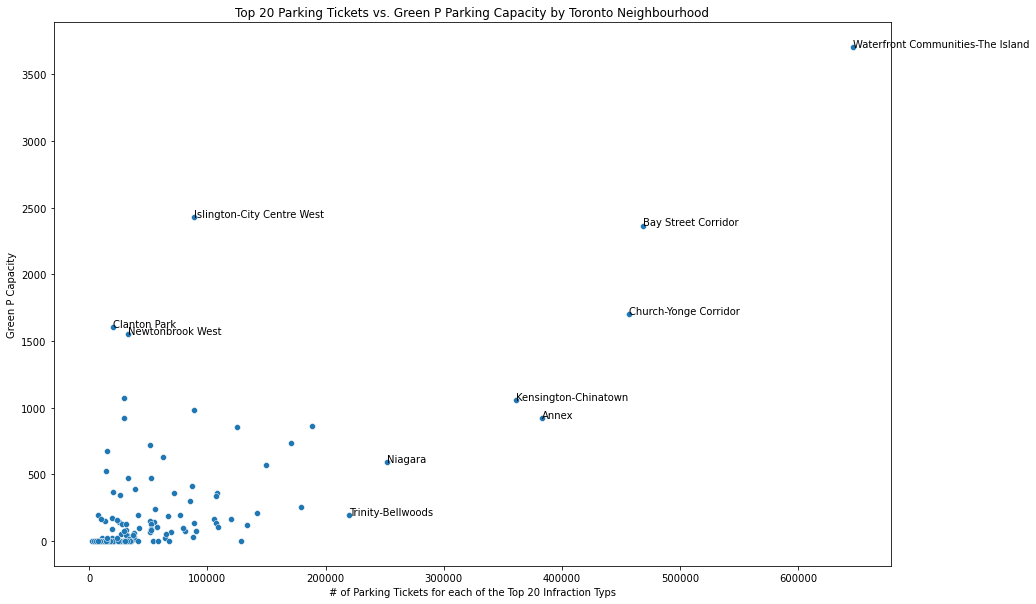

In [430]:
plt.figure(figsize=(15,10))

ax = sns.scatterplot(
    data=nb_vars,
    x=nb_vars['ticket_count'],
    y=nb_vars['green_p_capacity']
)

plt.title('Top 20 Parking Tickets vs. Green P Parking Capacity by Toronto Neighbourhood') # title
plt.xlabel('# of Parking Tickets for each of the Top 20 Infraction Typs')
plt.ylabel('Green P Capacity')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['x'] > 200000 or point['y'] > 1500:
            ax.text(point['x']+2, point['y']+1, str(point['val']))

label_point(nb_vars.ticket_count, nb_vars.green_p_capacity, nb_vars.AREA_NAME_y, plt.gca())

plt.show()

In [431]:
corr_df = pd.DataFrame(nb_vars[[
    #'AREA_NAME_y',
    'ticket_count',
    'green_p_count',
    'green_p_capacity',
    'Population density per square kilometre',
    'Population, 2016',
    'Total visible minority population',
    'Working Age (25-54 years)']]
)

# Replace commas in string formatted numbers
corr_df[[
    'Population density per square kilometre', 'Population, 2016',
    'Total visible minority population', 'Working Age (25-54 years)']] = corr_df[[
        'Population density per square kilometre', 'Population, 2016',
        'Total visible minority population', 'Working Age (25-54 years)'
]].applymap(lambda x: str(x.replace(',','')))

# Replace NaN with 0
corr_df_clean = corr_df.fillna(0)

# Convert to integer dtypes
corr_df_int = corr_df_clean.astype(int)

# Correlation matrix
corr_df_int.corr()

ticket_count  green_p_count  \
ticket_count                                 1.000000       0.665373   
green_p_count                                0.665373       1.000000   
green_p_capacity                             0.726409       0.655064   
Population density per square kilometre      0.392082       0.173418   
Population, 2016                             0.418516       0.276339   
Total visible minority population            0.123167      -0.083021   
Working Age (25-54 years)                    0.622228       0.458583   

                                         green_p_capacity  \
ticket_count                                     0.726409   
green_p_count                                    0.655064   
green_p_capacity                                 1.000000   
Population density per square kilometre          0.162471   
Population, 2016                                 0.429845   
Total visible minority population                0.160033   
Working Age (25-54 years)                        0.578081   

                                         Population density per square kilometre  \
ticket_count                                                            0.392082   
green_p_count                                                           0.173418   
green_p_capacity                                                        0.162471   
Population density per square kilometre                                 1.000000   
Population, 2016                                                        0.045926   
Total visible minority population                                      -0.029413   
Working Age (25-54 years)                                               0.199651   

                                         Population, 2016  \
ticket_count                                     0.418516   
green_p_count                                    0.276339   
green_p_capacity                                 0.429845   
Population density per square kilometre          0.045926   
Population, 2016                                 1.000000   
Total visible minority population                0.837803   
Working Age (25-54 years)                        0.936764   

                                         Total visible minority population  \
ticket_count                                                      0.123167   
green_p_count                                                    -0.083021   
green_p_capacity                                                  0.160033   
Population density per square kilometre                          -0.029413   
Population, 2016                                                  0.837803   
Total visible minority population                                 1.000000   
Working Age (25-54 years)                                         0.690460   

                                         Working Age (25-54 years)  
ticket_count                                              0.622228  
green_p_count                                             0.458583  
green_p_capacity                                          0.578081  
Population density per square kilometre                   0.199651  
Population, 2016                                          0.936764  
Total visible minority population                         0.690460  
Working Age (25-54 years)                                 1.000000

Text(0.5, 1.0, 'Parking Tickets Correlation Heatmap')

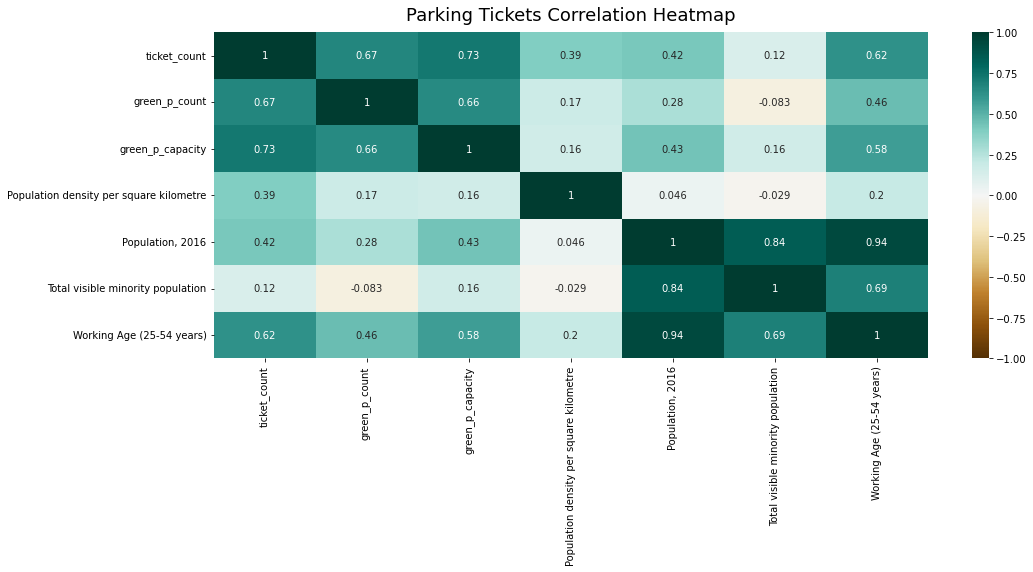

In [432]:
plt.figure(figsize=(16,6))

# heatmap of correlations
heatmap = sns.heatmap(
    corr_df_int.corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='BrBG'
)

# heatmap title
heatmap.set_title('Parking Tickets Correlation Heatmap', fontdict={'fontsize':18},pad=12)